## Import all what we need.

In [569]:
import os
import math
import glob
import time

import pylab
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from numba import jit
from io import StringIO
import matplotlib.pyplot as plt
import threading, multiprocessing

## The Input File Path


<table><tr><td bgcolor=skyblue><font size=24> Could be changed ! </font></td></tr></table>

In [570]:
inp_filepath = 'NO.inp'

ratio_air = 0.7
ratio_self = 0.3
cutoff = 25.0


## Report time

In [571]:
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

## Read Information from Input File

In [572]:
def inp_para(inp_filepath):
    
    inp_col_name = ['c0', 'c1', 'c2']
    inp_df = pd.read_csv(inp_filepath, sep='\\s+', names=inp_col_name, header=None)
    col0 = inp_df['c0']
    database = inp_df[col0.isin(['Database'])]['c1'].values[0]
    molecule = inp_df[col0.isin(['Molecule'])]['c1'].values[0]
    isotopologue = inp_df[col0.isin(['Isotopologue'])]['c1'].values
    iso = int(inp_df[col0.isin(['iso'])]['c1'])
    T = int(inp_df[col0.isin(['Temperature'])]['c1'])
    min_wn = float(inp_df[col0.isin(['Range'])]['c1'])
    max_wn = float(inp_df[col0.isin(['Range'])]['c2'])
    N_point = int(inp_df[col0.isin(['Npoints'])]['c1'])
    profile = inp_df[col0.isin(['Profile'])]['c1'].values[0]
    wn_wl = inp_df[col0.isin(['Wavenumber(wn)/wavelength(wl)'])]['c1'].values[0]
    par_filepath = inp_df[col0.isin(['Transitions'])]['c1'].values[0]
    saveplots = inp_df[col0.isin(['SavePlots'])]['c1'].values[0]
    savexsecs = inp_df[col0.isin(['SaveXsecs'])]['c1'].values[0]

    molecule_id = int(iso/10)
    isotopologue_id = iso - molecule_id * 10
    isometa_url = 'https://hitran.org/docs/iso-meta/'
    iso_meta_table = pd.read_html(isometa_url)[molecule_id - 1]
    iso_meta_row = iso_meta_table[iso_meta_table['local ID'].isin([isotopologue_id])]
    abundance = float(iso_meta_row['Abundance'][0].replace('\xa0×\xa010','E'))
    mass = float(iso_meta_row['Molar Mass /g·mol-1'])
    Q_ref = float(iso_meta_row.loc[0][6].replace('\xa0×\xa010','E'))
    Q_url = 'https://hitran.org/data/Q/' + iso_meta_row.loc[0][7]
    Q_content = requests.get(Q_url).text
    Q_col_name = ['T', 'Q']
    Q_df = pd.read_csv(StringIO(Q_content), sep='\\s+', names=Q_col_name, header=None)
    Q = Q_df['Q'][T - 1]
    
    return database, molecule, T, min_wn, max_wn, N_point, profile, wn_wl, par_filepath, saveplots, savexsecs, molecule_id, isotopologue_id, abundance, mass, Q_ref, Q


## Constants and Parameters

In [573]:
# HITRAN Parameters for calculating.
import astropy.constants as ac
database, molecule, T, min_wn, max_wn, N_point, profile, wn_wl, par_filepath, saveplots, savexsecs, molecule_id, isotopologue_id, abundance, mass, Q_ref, Q = inp_para(inp_filepath)
T_ref = 296                     # Reference temperature is 296 K.
P_ref = 1                       # Reference pressure is 1 atm.
P = 1
N_A = ac.N_A.value              # Avogadro number (mol^{-1})
h = ac.h.to('J s').value        # Planck's const (J s)
c = ac.c.to('cm/s').value       # Velocity of light (cm s^{-1})
kB = ac.k_B.to('J/K').value     # Boltzmann's const (J K^{-1})
c2 = h * c / kB                 # Second radiation constant (cm K)
c2_T = c2 / T                   # c2 / T (cm)
c2_T_ref = c2 / T_ref           # c2 / T_ref (cm)


## Read HITRAN Format Input File

Read the parameters of the molecular absorption features of HITRAN2016 format text file. Return the dataframe of the HITRAN data for the following calculations.

In [574]:
def read_hitran2016_parfile (par_filepath, parfile_df):
    '''
    Read the parameters of the molecular absorption features
    of HITRAN2016 format text file.
    
    Parameters
    ----------
    par_filepath : str
        Input file path for reading.
    Return
    ------
    hitran_df : DataFrame
        The DataFrame of HITRAN data for the molecule.
    '''    
    par_filename = par_filepath.split('/')[3]
    
    if not os.path.exists:
        raise ImportError('The input file ' + par_filename + ' does not exist.')

    #par_df = dict()
    #parfile_df = pd.DataFrame()

    #par_df[par_filepath] = pd.read_csv(par_filepath, header=None, chunksize=100_000_000, iterator=True, low_memory=False)
    #for chunk in par_df[par_filepath]:
    #    parfile_df = parfile_df.append(chunk)

    if (len(str(parfile_df[0][0])) < 160):
        raise ImportError('The file ' + par_filename + ' is not a HITRAN2016 format data file.')
    #hitran_column_name = ['M','I','v','S','Acoeff','gamma_air','gamma_self',
    #                     'Epp','n_air','delta_air','Vp','Vpp','Qp','Qpp',
    #                     'Ierr','Iref','flag','gp','gpp']

    hitran_df = pd.DataFrame()

    hitran_df['M'] = pd.to_numeric(parfile_df[0].map(lambda x: x[0:2]), errors='coerce').astype('int64')                 # Molecule identification number
    hitran_df['I'] = pd.to_numeric(parfile_df[0].map(lambda x: x[2:3]), errors='coerce').astype('int64')                 # Isotopologue number
    hitran_df['v'] = pd.to_numeric(parfile_df[0].map(lambda x: x[3:15]), errors='coerce').astype('float64')              # Transition wavenumber (in cm^{-1})
    hitran_df['S'] = pd.to_numeric(parfile_df[0].map(lambda x: x[15:25]), errors='coerce').astype('float64')             # Intensity (cm^{-1} / (molecule cm^{-2})
    hitran_df['Acoeff'] = pd.to_numeric(parfile_df[0].map(lambda x: x[25:35]), errors='coerce').astype('float64')        # Einstein A-coefficient (in s^{-1})
    hitran_df['gamma_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[35:40]), errors='coerce').astype('float64')     # Air-broadened half-width at half maximum (HWHM) coefficient (cm^{-1} atm^{-1})
    hitran_df['gamma_self'] = pd.to_numeric(parfile_df[0].map(lambda x: x[40:45]), errors='coerce').astype('float64')    # Self-broadened half-width at half maximum (HWHM) coefficient (cm^{-1} atm^{-1})
    hitran_df['Epp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[45:55]), errors='coerce').astype('float64')           # Lower state energy (cm^{-1})
    hitran_df['n_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[55:59]), errors='coerce').astype('float64')         # Temperature-dependent exponent for gamma_air
    hitran_df['delta_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[59:67]), errors='coerce').astype('float64')     # Air pressure_include line shift (cm^{-1} atm^{-1})
    hitran_df['Vp'] = parfile_df[0].map(lambda x: x[67:82])                                                              # Upper-state "global" quanta
    hitran_df['Vpp'] = parfile_df[0].map(lambda x: x[82:97])                                                             # Lower-state "global" quanta
    hitran_df['Qp'] = parfile_df[0].map(lambda x: x[97:112])                                                             # Upper-state "local" quanta
    hitran_df['Qpp'] = parfile_df[0].map(lambda x: x[112:127])                                                           # Lower-state "local" quanta
    hitran_df['Ierr'] = parfile_df[0].map(lambda x: x[127:133])                                                          # Uncertainty indices
    hitran_df['Iref'] = parfile_df[0].map(lambda x: x[133:145])                                                          # Reference indices
    hitran_df['flag'] = parfile_df[0].map(lambda x: x[145:146])                                                          # Flag
    hitran_df['gp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[146:153]), errors='coerce').astype('float64')          # Statistical weight of the upper state
    hitran_df['gpp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[153:160]), errors='coerce').astype('float64')         # Statistical weight of the lower state

    #hitran_df = hitran_df[hitran_df['I'].isin([1])]
    
    return hitran_df


## Line Profile

## Calculate Cross Sections

## Plot and Save Results

In [575]:
def hitran_data_prepare(hitran_df):
    '''
    Read HITRAN .par file as the input file.
    Return the data for calculating wavennumbers and cross sections with line profiles.
    
    '''
    #hitran_df = hitran_df[hitran_df['v'].between(min_wn, max_wn)]
    hitran_df = hitran_df[hitran_df['v'].between(min_wn - cutoff, max_wn + cutoff)]
    #nlines = len(hitran_df)
    #wn_grid = np.linspace(min_wn - cutoff, max_wn + cutoff, N_point)
    wn_grid = np.linspace(min_wn, max_wn, N_point)
    S = hitran_df['S'].values
    Epp = hitran_df['Epp'].values
    n_air = hitran_df['n_air'].values
    gamma_air = hitran_df['gamma_air'].values
    gamma_self = hitran_df['gamma_self'].values
    v = hitran_df['v'].values + hitran_df['delta_air'].values * (P - P_ref) / P
    #v = hitran_df['v'].values
    
    return (wn_grid, S, Epp, n_air, gamma_air, gamma_self, v)

In [576]:
@jit("(float64[:](float64[:], float64, int32))", nopython=True)
def Doppler_HWHM (v, mass, T):
    '''Return the Doppler half-width at half-maximum (HWHM) -- alpha.'''
    alpha = np.sqrt(2 * N_A * kB * T * np.log(2) / mass) * v / c
    return alpha

In [577]:
@jit("(float64[:](int32, int32, float64[:], float64[:], float64[:]))", nopython=True)
def Lorentzian_HWHM (T, P, n_air, gamma_air, gamma_self):
    '''Return the Lorentzian half-width at half-maximum (HWHM) -- gamma.'''
    gamma = (gamma_air * ratio_air + gamma_self * ratio_self) * ((T_ref / T)**n_air) * (P / P_ref)
    return gamma

In [578]:
@jit("(float64[:](float64[:], int32, int32, float64[:], int32, int32, float64[:]))", nopython=True)
def cal_abscoefs(v, T, T_ref, S, Q, Q_ref, Epp):
    abscoef = S * Q_ref / Q * np.exp(c2 * Epp * (1/T_ref - 1/T)) * (1 - np.exp(-c2_T * v)) / (1 - np.exp(-c2_T_ref * v))
    return (abscoef)

In [579]:
@jit("(float64[:](float64[:], float64[:]))", nopython=True)
def Lorentzian_profile(dv, gamma):
    '''Return Lorentzian line profile at dv with HWHM gamma.'''
    gamma = gamma * 2
    Lorentzian_profile = gamma / np.pi / (dv**2 + gamma**2)
    return Lorentzian_profile


In [580]:
def scipy_Voigt_profile(dv, alpha, gamma):
    '''
    Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.

    '''
    from scipy.special import voigt_profile
    return voigt_profile(dv, alpha, gamma)

In [581]:
def hitran_cross_section_Lorentzian(wn_grid, v, gamma, abscoef):
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with Lorentzian profile.
    
    '''
    xsec_l = np.zeros_like(wn_grid)
    _xsec_l = np.zeros_like(wn_grid)
    
    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = np.array(dv[filter_cutoff])
        _gamma = np.array(gamma[filter_cutoff])
        _abscoef = abscoef[filter_cutoff]
        _xsec_l[i] = np.sum(_abscoef * Lorentzian_profile(_dv, _gamma))        

    xsec_l[0:N_point] += _xsec_l

    return (xsec_l)

In [582]:
def hitran_cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, abscoef):
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with scipy Voigt profile.
    
    '''
    xsec_sv = np.zeros_like(wn_grid)
    _xsec_sv = np.zeros_like(wn_grid)

    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = dv[filter_cutoff]
        _alpha = alpha[filter_cutoff]
        _gamma = gamma[filter_cutoff]
        _abscoef = abscoef[filter_cutoff]
        _xsec_sv[i] = np.sum(_abscoef * scipy_Voigt_profile(_dv, _alpha, _gamma))

    xsec_sv[0:N_point] += _xsec_sv

    return (xsec_sv)

In [583]:
def plot_hitran_xsec_Lorentzian(wn, xsec_l):
    if (wn_wl == 'wn'):
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavenumber range selected: ', min_wn, 'cm-1 - ', max_wn, 'cm-1')
        
        xsec_l_df = pd.DataFrame()
        xsec_l_df['wavenumber'] = wn
        xsec_l_df['cross-section'] = xsec_l
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__Lorentzian__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wn,xsec_l)).T)
        print('Saved xsec file.')
        
        #fig = plt.figure(figsize=(12, 6))
        plt.plot(wn, xsec_l, label='T = 500 K, Lorentzian profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__Lorentzian__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')
        
    elif wn_wl == 'wl':
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavelength range selected: ', min_wl, 'nm - ', max_wl, 'nm')
        
        xsec_l_df = pd.DataFrame()
        xsec_l_df['wavelength'] = wl
        xsec_l_df['cross-section'] = xsec_l
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__Lorentzian__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wl,xsec_l)).T)
        print('Saved xsec file.')
        
        #fig = plt.figure(figsize=(12, 6))
        plt.plot(wl, xsec_l, label='T = 500 K, Lorentzian profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__Lorentzian__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')

    else:
        print('Please type in correct format: wn or wl.')

In [584]:
def plot_hitran_xsec_scipy_Voigt(wn, xsec_sv):
    if wn_wl =='wn':      
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavenumber range selected: ', min_wn, 'cm-1 - ', max_wn, 'cm-1')
        
        xsec_sv_df = pd.DataFrame()
        xsec_sv_df['wavenumber'] = wn
        xsec_sv_df['cross-section'] = xsec_sv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__ScipyVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wn,xsec_sv)).T)
        print('Saved xsec file.')
        
        plt.plot(wn, xsec_sv, label='T = 500 K, scipy Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__ScipyVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')

    elif wn_wl == 'wl':
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavelength range selected: ', min_wl, 'nm - ', max_wl, 'nm')
        
        xsec_sv_df = pd.DataFrame()
        xsec_sv_df['wavelength'] = wl
        xsec_sv_df['cross-section'] = xsec_sv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__ScipyVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wl,xsec_sv)).T)
        print('Saved xsec file.')
        
        plt.plot(wl, xsec_sv, label='T = 500 K, scipy Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__ScipyVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')
        
    else:
        print('Please type in correct format: wn or wl.')

In [585]:
def get_results(parfile_df):
    if database == 'HITRAN':
        hitran_df = read_hitran2016_parfile (par_filepath, parfile_df)
        wn_grid, S, Epp, n_air, gamma_air, gamma_self, v = hitran_data_prepare(hitran_df)

    elif database == 'ExoMol':
        print('Please run the code in folder ExoMol_format.')
    else:
        print('Please add the name of the database HITRAN or ExoMol into the input file.')
    
    abscoef = cal_abscoefs(v, T, T_ref, S, Q, Q_ref, Epp)
    
    #if profile == 'Gaussian':
    #    plot_hitran_xsec_Gaussian()
    if profile == 'Lorentzian':
        gamma = Lorentzian_HWHM (T, P, n_air, gamma_air, gamma_self)
        xsec_l = hitran_cross_section_Lorentzian(wn_grid, v, gamma, abscoef)
        plot_hitran_xsec_Lorentzian(wn_grid, xsec_l)
    elif profile == 'scipy_Voigt':
        alpha = Doppler_HWHM (v, mass, T)
        gamma = Lorentzian_HWHM (T, P, n_air, gamma_air, gamma_self)
        xsec_sv = hitran_cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, abscoef)
        plot_hitran_xsec_scipy_Voigt(wn_grid, xsec_sv)
    #elif profile == 'scipy_wofz_Voigt':
    #    plot_hitran_xsec_scipy_wofz_Voigt()
    #elif profile == 'width_Voigt':
    #    plot_hitran_xsec_width_Voigt()
    #elif profile == 'pseudo_Voigt':
    #    plot_hitran_xsec_pseudo_Voigt()
    #elif profile == 'pseudo_FWHM_Voigt':
    #    plot_hitran_xsec_pseudo_FWHM_Voigt()
    else:
        print('Please choose line profile from the list.')
    pass

In [586]:
start = time.clock()
par_filename = par_filepath.split('/')[3]
    
if not os.path.exists:
    raise ImportError('The input file ' + par_filename + ' does not exist.')

# Initialise the iterator object.
iterator = pd.read_csv(par_filepath, chunksize=100_000_000, header=None, encoding='utf-8')
# Depends on how many cores you want to utilise.
# Reserve 64 cores for our script.
max_processors = 64       
pool = multiprocessing.Pool(processes=max_processors)
f_list = []
for parfile_df in iterator:
    f = pool.apply_async(get_results, [parfile_df])
    f_list.append(f)
    if len(f_list) >= max_processors:
        for f in f_list:
            f.get()
            del f_list[:]

end = time.clock()
t = end - start
print('Total running time :', t, 's')

Total running time : 11.34976000000006 s
Temperature selected:  500 K
Pressure selected:  1 bar
Air broading is:  0.7
Self broading is:  0.3
Wavenumber range selected:  2000.0 cm-1 -  10000.0 cm-1
Saved xsec file.


In [587]:
Q_ref

1141.1

In [588]:
parfile_df = pd.read_csv(par_filepath, header=None, encoding='utf-8')

In [589]:
hitran_df = read_hitran2016_parfile (par_filepath, parfile_df)
wn_grid, S, Epp, n_air, gamma_air, gamma_self, v = hitran_data_prepare(hitran_df)
abscoef = cal_abscoefs(v, T, T_ref, S, Q, Q_ref, Epp)

In [590]:
alpha = Doppler_HWHM (v, mass, T)
gamma = Lorentzian_HWHM (T, P, n_air, gamma_air, gamma_self)


100%|██████████| 80001/80001 [00:14<00:00, 5359.13it/s]


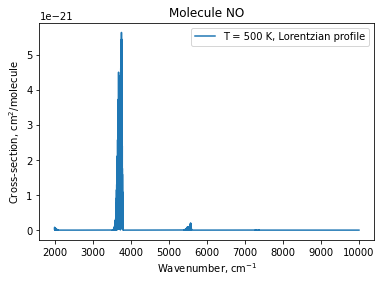

Saved xsec plots.


In [591]:
xsec_sv = np.zeros_like(wn_grid)
_xsec_sv = np.zeros_like(wn_grid)
for i in tqdm(range(len(wn_grid))):
        
    dv = wn_grid[i] - v
    filter_cutoff = np.abs(dv) <=cutoff
    _dv = dv[filter_cutoff]
    _alpha = alpha[filter_cutoff]
    _gamma = gamma[filter_cutoff]
    _abscoef = abscoef[filter_cutoff]
    _xsec_sv[i] = np.sum(_abscoef * scipy_Voigt_profile(_dv, _alpha, _gamma))

xsec_sv[0:len(wn_grid)] += _xsec_sv


In [592]:
xsec_l = hitran_cross_section_Lorentzian(wn_grid, v, gamma, abscoef)